In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
import os
import joblib
import warnings
warnings.filterwarnings('ignore')

In [77]:
def create_directories():
    """
    Create necessary directories if they don't exist
    """
    directories = ['../data/processed', '../models', '../results']
    for directory in directories:
        os.makedirs(directory, exist_ok=True)
        print(f"Created directory: {directory}")


In [78]:
def prepare_data():
    """
    Load processed data and split into train/test sets
    """
    print("\nPreparing data...")
    
    # Load the processed data
    df = pd.read_csv('../data/processed/processed_data.csv')
    print("Loaded processed data shape:", df.shape)
    
    # Separate features and target
    target = 'Delayed'
    features = [col for col in df.columns if col != target]

    # Identify non-numeric columns
    non_numeric_cols = df[features].select_dtypes(include=['object']).columns.tolist()
    if non_numeric_cols:
        print(f"\nNon-numeric columns detected: {non_numeric_cols}")

    # Drop or encode non-numeric columns
    df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

    features = [col for col in df.columns if col != target]

    X = df[features]
    y = df[target]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2,
        random_state=42,
        stratify=y
    )
    
    # Save the split datasets
    X_train.to_csv('../data/processed/X_train.csv', index=False)
    X_test.to_csv('../data/processed/X_test.csv', index=False)
    y_train.to_csv('../data/processed/y_train.csv', index=False)
    y_test.to_csv('../data/processed/y_test.csv', index=False)
    
    print("Train-test split complete:")
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Testing set: {X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

In [79]:
def analyze_correlations(X_train):
    """
    Analyze and plot feature correlations
    """
    print("\nAnalyzing feature correlations...")
    
    plt.figure(figsize=(12, 8))
    correlation_matrix = X_train.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix')
    plt.tight_layout()
    plt.close()
    
    # Print high correlations
    threshold = 0.5
    high_corr = np.where(np.abs(correlation_matrix) > threshold)
    high_corr = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y])
                 for x, y in zip(*high_corr) if x != y and x < y]
    
    if high_corr:
        print("\nHigh correlations (>0.5):")
        for feat1, feat2, corr in high_corr:
            print(f"{feat1} - {feat2}: {corr:.2f}")

In [80]:
def scale_features(X_train, X_test):
    """
    Scale numerical features
    """
    print("\nScaling features...")

    # Identify numeric columns for scaling
    numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
    scaler = StandardScaler()

    # Scale numeric columns
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    return X_train_scaled, X_test_scaled, scaler


def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a single model
    """
    print(f"\nEvaluating {model_name}...")
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    accuracy = accuracy_score(y_test, y_pred)
    # auc = roc_auc_score(y_test, y_pred_proba)
    
    # Print results
    print(f"\n{model_name} Results:")
    print("-" * 20)
    print(f"Cross-validation accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    print(f"Test accuracy: {accuracy:.3f}")
    # print(f"ROC AUC: {auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # # Plot ROC curve
    # plt.figure(figsize=(8, 6))
    # fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    # plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([0.0, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve - {model_name}')
    # plt.legend(loc="lower right")
    # # plt.savefig(f'results/roc_curve_{model_name.lower().replace(" ", "_")}.png')
    # plt.close()
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'results/confusion_matrix_{model_name.lower().replace(" ", "_")}.png')
    plt.close()
    
    return {
        'model': model,
        'accuracy': accuracy,
        # 'auc': auc,
        'cv_scores': cv_scores,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

In [81]:
def train_models(X_train, X_test, y_train, y_test):
    """
    Train and evaluate multiple models
    """
    print("\nTraining multiple models...")
    
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42)
    }
    
    results = {}
    for name, model in models.items():
        results[name] = evaluate_model(model, X_train, X_test, y_train, y_test, name)
    
    # Find best model
    best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
    print(f"\nBest performing model: {best_model_name}")
    
    return results, best_model_name

def optimize_best_model(best_model_name, results, X_train, X_test, y_train, y_test):
    """
    Perform hyperparameter optimization on the best model
    """
    print(f"\nOptimizing {best_model_name}...")
    
    best_model = results[best_model_name]['model']
    
    if isinstance(best_model, RandomForestClassifier):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    elif isinstance(best_model, GradientBoostingClassifier):
        param_grid = {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 4, 5],
            'min_samples_split': [2, 5, 10]
        }
    else:
        print("Optimization skipped - no parameter grid defined for this model type")
        return best_model
    
    grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("\nBest parameters:", grid_search.best_params_)
    print("Best cross-validation accuracy:", grid_search.best_score_)
    
    # Evaluate optimized model
    optimized_results = evaluate_model(
        grid_search.best_estimator_,
        X_train, X_test, y_train, y_test,
        f"Optimized {best_model_name}"
    )
    
    return grid_search.best_estimator_

In [82]:
def save_models(model, scaler, model_name):
    """
    Save the trained model and scaler
    """
    print("\nSaving models...")
    
    # Save the model
    model_filename = f'models/optimized_{model_name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model, model_filename)
    print(f"Saved model: {model_filename}")
    
    # Save the scaler
    scaler_filename = 'models/scaler.pkl'
    joblib.dump(scaler, scaler_filename)
    print(f"Saved scaler: {scaler_filename}")

Starting model development pipeline...
Created directory: ../data/processed
Created directory: ../models
Created directory: ../results

Preparing data...
Loaded processed data shape: (20000, 23)

Non-numeric columns detected: ['Shipment_Date', 'Planned_Delivery_Date', 'Actual_Delivery_Date']
Train-test split complete:
Training set: 16000 samples
Testing set: 4000 samples

Analyzing feature correlations...

High correlations (>0.5):
Distance_(km) - Planned_Delivery_Days: 0.96
Distance_(km) - Actual_Delivery_Days: 0.64
Distance_(km) - Is_Long_Distance: 0.87
Weather_Conditions - Is_Bad_Weather: 0.91
Traffic_Conditions - Is_Heavy_Traffic: -0.75
Planned_Delivery_Days - Actual_Delivery_Days: 0.62
Planned_Delivery_Days - Is_Long_Distance: 0.84
Actual_Delivery_Days - Delay_Days: 0.74
Actual_Delivery_Days - Is_Long_Distance: 0.55
Delay_Days - Avg_Speed: -0.78
Shipment_Month - Shipment_Quarter: 0.97
Shipment_Day_Of_Week - Is_Weekend: 0.79
Planned_Delivery_Date_2023-01-03 - Actual_Delivery_Date_2

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\mansi\\Arogo_AI\\Problem_Statements_Arogo\\Freight_Logistics\\notebooks\\results\\confusion_matrix_logistic_regression.png'

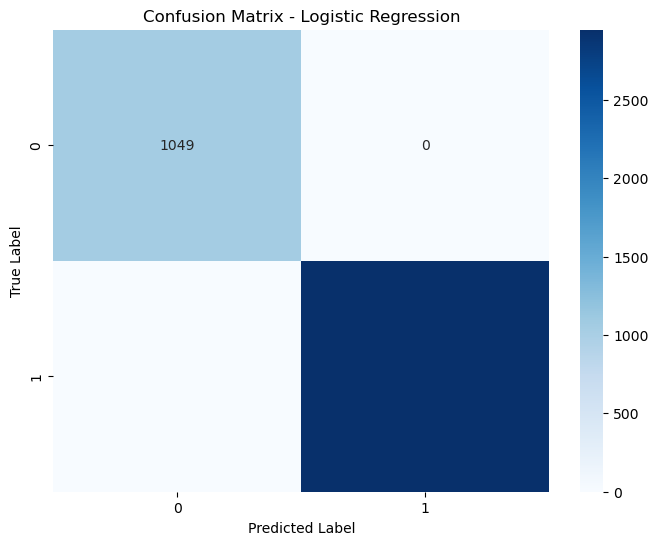

In [83]:
def main():
    """
    Main execution pipeline
    """
    print("Starting model development pipeline...")
    
    # Create necessary directories
    create_directories()
    
    # Prepare data
    X_train, X_test, y_train, y_test = prepare_data()
    
    # Analyze correlations
    analyze_correlations(X_train)
    
    # Scale features
    X_train_scaled, X_test_scaled, scaler = scale_features(X_train, X_test)
    
    # Train and evaluate models
    results, best_model_name = train_models(X_train_scaled, X_test_scaled, y_train, y_test)
    
    # Optimize best model
    optimized_model = optimize_best_model(
        best_model_name, results, 
        X_train_scaled, X_test_scaled, 
        y_train, y_test
    )
    
    # Save models
    save_models(optimized_model, scaler, best_model_name)
    
    print("\nModel development pipeline completed!")
    print("Check the 'results' directory for plots and the 'models' directory for saved models.")

if __name__ == "__main__":
    main()